In [2]:
import pandas as pd
import numpy as np

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

In [4]:
def reduce_img_colours(img_path, compression = 1, num_colours = 5):
    
    img = Image.open(img_path)
    
    new_size = (np.array(img.size) * compression).astype(int)
    
    img_array = np.array(img.resize(new_size))
    
    pixels = img_array.reshape((-1, 3))
    
    kmeans = MiniBatchKMeans(num_colours).fit(pixels)
    
    new_pixels = kmeans.cluster_centers_[kmeans.labels_]
    
    new_img = new_pixels.reshape((new_size[1], new_size[0], 3))
    
    print(f'# Old colours: {len(np.unique(pixels, axis = 0))}')
    print(f'# New colours: {num_colours}')
    
    return new_img

In [ ]:
#read in sim

In [5]:
# https://github.com/google-research-datasets/conceptual-captions/blob/master/LICENSE
# https://ai.google.com/research/ConceptualCaptions/download
data = pd.read_csv('../raw_data/Validation_GCC-1.1.0-Validation.tsv', sep = '\t', header = None)

In [6]:
data.columns = ['caption', 'url']

In [6]:
import requests
from PIL import Image
import PIL
import io
import torch
import clip

def get_pil_image(url):
    
    try:
        response = requests.get(url)
        if response.status_code == 200:
                return Image.open(io.BytesIO(response.content))
    
    except requests.exceptions.RequestException:
        return None
    except PIL.UnidentifiedImageError:
        return None
#     except RuntimeError:
#         return None


def square_image(pil_img):
    
    short_side = min(pil_img.size)
    
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - short_side) // 2,
                         (img_height - short_side) // 2,
                         (img_width + short_side) // 2,
                         (img_height + short_side) // 2))

def simplify_image(pil_img, num_colors = 8):

    img = pil_img.quantize(colors=num_colors, method=2)
    
    sq_img = square_image(img).resize((128, 128), Image.LANCZOS)
    
    return sq_img
    
def save_img(pil_img, caption, destination_folder):
    
    file_name = f"{destination_folder}/{caption.replace('.', '')}.png"
    
    #print('saving to ', file_name)
    
    pil_img.save(file_name)
    


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


def clip_encode_image(pil_img):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    image = preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)

    return image_features



In [10]:
from tqdm import tqdm

features_list = []
image_path_list = []

for i, row in tqdm(data[2100:].iterrows()):
    
    url, caption = row['url'], row['caption']
    
    #print(url)

    img = get_pil_image(url)
    
    if img:

        features_list.append(clip_encode_image(img)[0])

        simple_img = simplify_image(img, num_colors = 256)

        save_img(simple_img, caption, destination_folder = '../raw_data/images2')
        
        image_path_list.append(f"{caption.replace('.', '')}.png")
    if len(features_list) % 10 == 0:
        print(len(features_list))
        
        

#image = get_simplified_image(url, caption, destination_folder = '../raw_data/images', num_colors = 256)

11it [00:21,  1.72s/it]

10


12it [00:22,  1.54s/it]

10
10


14it [00:23,  1.02s/it]

10


25it [00:39,  1.88s/it]

20


37it [00:56,  1.18s/it]

30


47it [01:06,  1.02s/it]

40


58it [01:19,  1.15s/it]

50


68it [01:31,  1.18s/it]

60


78it [01:45,  1.45s/it]

70


91it [01:58,  1.44it/s]

80


103it [06:12, 35.03s/it]

90


115it [06:25,  1.32s/it]

100


127it [06:47,  1.70s/it]

110


138it [07:03,  1.60s/it]

120


148it [9:43:19, 236.48s/it]


KeyboardInterrupt: 

In [ ]:
image_embeddings = np.stack(features_list)

In [ ]:
X_image_embeddings = torch.from_numpy(image_embeddings)
X_image_embeddings.shape

In [163]:
# mnist = pymde.datasets.MNIST()
# mnist.data

In [226]:
import pymde

mde = pymde.preserve_neighbors(X_image_embeddings, embedding_dim=2, verbose=True)
embedding = mde.embed(verbose=True)

Jul 02 09:08:58 AM: Computing 5-nearest neighbors, with max_distance=None
Jul 02 09:08:58 AM: Exact nearest neighbors by brute force 
Jul 02 09:08:58 AM: Computing quadratic initialization.
Jul 02 09:08:58 AM: Fitting a centered embedding into R^2, for a graph with 658 items and 4781 edges.
Jul 02 09:08:58 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Jul 02 09:08:58 AM: iteration 000 | distortion 0.553629 | residual norm 0.191558 | step length 0.361071 | percent change 0.190663
Jul 02 09:08:58 AM: iteration 030 | distortion 0.285116 | residual norm 0.00227742 | step length 1 | percent change 0.548105
Jul 02 09:08:59 AM: iteration 060 | distortion 0.281150 | residual norm 0.000921155 | step length 1 | percent change 0.704568
Jul 02 09:08:59 AM: iteration 090 | distortion 0.278932 | residual norm 0.000835439 | step length 1 | percent change 0.664096
Jul 02 09:08:59 AM: iteration 120 | distortion 0.277878 | residual norm 0.000492494 | step length 1 | percent ch

In [227]:
image_path_list

['author : a life in photography -- in pictures.png',
 'the player staring intently at a computer screen .png',
 'the - bedroom stone cottage can sleep people.png',
 'party in the park under cherry blossoms.png',
 'a man holds what is believed to be some of the debris that caused damage to vehicles monday afternoon after airliner returned to airport following problems after take off .png',
 "where 's the best place to show off your nails ? right in front of the castle , of course !.png",
 'that combines elements of a simple vegetable and dish.png',
 'transformers : till all are issue # 4b.png',
 'illustration of a little girl taking a bath.png',
 'tv police procedural is filming on the street this week .png',
 'the new terminal on island with quiet sea and setting sun.png',
 'what makeup to wear to a job interview.png',
 'the dentist drill the tooth with a turbine.png',
 'pair of new bright orange modern sneakers isolated on a white background.png',
 'ask industry to do in our family r

In [251]:
def embedding_to_coords(embedding, coord, scale = 1000):
    
    if coord == 'X':
        col = 0
    elif coord == 'Y':
        col = 1
    else:
        print("coord must be X or Y")
    
    coords = embedding.numpy()[:, col]

    from_one = coords - min(coords)

    return [int(coord) for coord in (from_one / max(from_one) * scale)]

In [230]:
clean_image_path_list = image_path_list

In [1]:
clean_image_path_list

NameError: name 'clean_image_path_list' is not defined

In [2]:
import string

def clean_png_path(file_name):
    
    suffix = file_name[-4:]
    
    clean_file_name = ''.join([char for char in file_name[:-4] if char not in string.punctuation])
    
    return '_'.join(clean_file_name.split()) +  suffix # remove multiple whitespace

clean_png_path('author : a life in photography -- in pictures.png')

'author_a_life_in_photography_in_pictures.png'

In [1]:
clean_image_path_list = [clean_png_path(path) for path in clean_image_path_list]

NameError: name 'clean_image_path_list' is not defined

In [252]:
import json

X_coords = embedding_to_coords(embedding, 'X', scale = 1)
Y_coords = embedding_to_coords(embedding, 'Y', scale = 1)

map_json = {
    "X_coords": X_coords,
    "Y_coords": Y_coords,
    "image_paths": clean_image_path_list
}
map_json['image_paths'][0]
with open('../raw_data/latent_space_map.json', 'w') as f:
    json.dump(map_json, f)


In [253]:
os.listdir('../raw_data/images')

['beverage_type_the_original_beer.png',
 'film_actor_attends_the_premiere_during_film_festival_and_festivals.png',
 'politicians_speaking_at_an_event.png',
 'man_carrying_pond_in_the_mountain.png',
 'leading_lady_actor_is_heading_up_the_cast_as_the_accused_woman_herself.png',
 'i_m_not_one_for_facial_piercings_but_i_must_say_that_fictional_character_can_be_really_beautiful.png',
 'fresh_green_forest_and_gentle_river_after_the_rain.png',
 'shoppers_struggle_through_the_heavy_snow.png',
 'person_feeding_apples_to_an_elephant_in_captivity.png',
 'the_tattoo_is_wrapped_in_cling_film_to_protect_it_for_the_first_night.png',
 'a_man_hiking_through_the_woods_looks_around_the_forest_and_then_smiles_at_the_camera_in_slow_motion.png',
 'cinematic_style_video_of_young_student_in_cafe.png',
 'hands_down_the_top_question_we_get_asked_is_how_to_achieve_a_consistent_style_in_your_home.png',
 'stylish_couple_actor_and_organisation_founder_put_on_a_loved_up_display_as_they_enjoyed_day_on_monday.png',
 '

In [249]:
### rename images

# import os

# directory_path = '../raw_data/images'

# for file_name in os.listdir(directory_path):
#     os.rename(f'{directory_path}/{file_name}', f'{directory_path}/{clean_png_path(file_name)}')

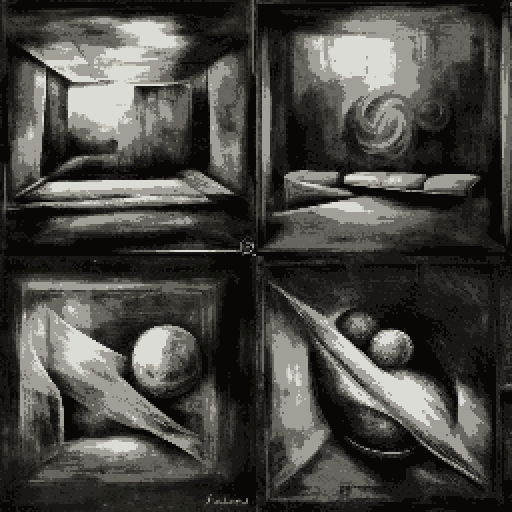

In [281]:
pil_img = Image.open('../raw_data/mj_background.png')
img = pil_img.quantize(colors=32, method=2).resize((256, 256), Image.LANCZOS).resize((512, 512), Image.LANCZOS)
img

In [282]:
img.save('../raw_data/latent_space_background_32bit.png')

In [7]:
def simplify_image(pil_img, num_colors = 8, size = (256, 256)):

    img = pil_img.quantize(colors=num_colors, method=2)
    
    sq_img = square_image(img).resize(size, Image.LANCZOS)
    
    return sq_img

In [8]:
#!mkdir ../raw_data/images_simple

In [352]:
pil_img = Image.open('../raw_data/latent_space_background_32bit.png')

img = simplify_image(pil_img, num_colors = 8, size = (128, 128))

In [353]:
# img.save('../raw_data/latent_space_background_256bit.png')

In [9]:
import numpy as np

In [19]:
def add_border(old_img, width = 6):
    img_arr = np.array(old_img)

    old_size = old_img.size
    
    new_size = [size + width for size in old_size]

    #new_size = (800, 800)
    new_img = Image.new("RGB", new_size, 'White')
    box = tuple((n - o) // 2 for n, o in zip(new_size, old_size))
    new_img.paste(old_img, box)
    
    return new_img

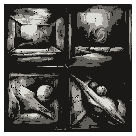

In [360]:
add_border(img, width = 8)

In [21]:
!mkdir ../raw_data/artist_images_semisimple/

In [22]:
import os
from tqdm import tqdm
for file_name in tqdm(os.listdir("../raw_data/artist_images")):
    if file_name.endswith('.png'):
        pil_img = Image.open(f"../raw_data/artist_images/{file_name}")
        simp_img = simplify_image(pil_img, num_colors = 256, size = (240, 240))
        border_img = add_border(simp_img, width = 8)
        border_img.save(f"../raw_data/artist_images_semisimple/{file_name}")

100%|█████████████████████████████████████████| 480/480 [00:30<00:00, 15.62it/s]


### choose less images and reduce the scale of the json